This notebook for Stardist applicationis adoptted from https://github.com/stardist/stardist/blob/main/examples/2D/3_prediction.ipynb

Students can use this as an initial notebook for more images with specific models and parameters.

Liya Ding 2024.10.01

In [1]:
import sys
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from csbdeep.utils import normalize
from csbdeep.utils import download_and_extract_zip_file
import tifffile
from skimage.transform import resize
from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D
import pandas as pd
np.random.seed(6)
lbl_cmap = random_label_cmap()

2025-01-15 21:24:38.161454: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 21:24:38.459028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 21:24:39.144791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
root_folder = '/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Microtubule_GUV-Liu-20250106T211105Z-001'

folder_list = [x for x in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, x)) ]

In [14]:
folder_list

['Microtubule_GUV-Liu']

In [15]:
df = pd.DataFrame(columns=['folder_path','file_name','condition','date'])

for  folder_ID in range(len(folder_list)):
    sub_folder = os.path.join(root_folder, folder_list[folder_ID])
    print(sub_folder)
    sub_folder_list = [x for x in os.listdir(sub_folder) if os.path.isdir(os.path.join(sub_folder, x)) ]
    for  sub_folder_ID in range(len(sub_folder_list)):
        sub_sub_folder =  os.path.join(sub_folder, sub_folder_list[sub_folder_ID])
        # print(sub_sub_folder)
        sub_sub_folder_list = [x for x in os.listdir(sub_sub_folder) if os.path.isdir(os.path.join(sub_sub_folder, x)) ]
        for  sub_sub_folder_ID in range(len(sub_sub_folder_list)):
            sub_sub_sub_folder =  os.path.join(sub_sub_folder, sub_sub_folder_list[sub_sub_folder_ID])
            # print(sub_sub_sub_folder)
            sub_sub_sub_folder_list = [x for x in os.listdir(sub_sub_sub_folder) if os.path.isdir(os.path.join(sub_sub_sub_folder, x)) and ('Microtubule' in x) ]
            for  sub_sub_sub_folder_ID in range(len(sub_sub_sub_folder_list)):
                sub_sub_sub_sub_folder =  os.path.join(sub_sub_sub_folder, sub_sub_sub_folder_list[sub_sub_sub_folder_ID])
                # print(sub_sub_sub_sub_folder)
                sub_sub_sub_filename_list = [x for x in os.listdir(sub_sub_sub_sub_folder) if os.path.isfile(os.path.join(sub_sub_sub_sub_folder, x)) and ('.TIF' in x) ]
                for  sub_sub_sub_filename_ID in range(len(sub_sub_sub_filename_list)):
                    filename =  sub_sub_sub_filename_list[sub_sub_sub_filename_ID]
                    file_path = os.path.join(sub_sub_sub_sub_folder, sub_sub_sub_filename_list[sub_sub_sub_filename_ID])
                    # print(file_path)                    
                    s = pd.DataFrame([[sub_sub_sub_sub_folder, filename, sub_folder_list[sub_folder_ID],sub_sub_folder_list[sub_sub_folder_ID]]],columns=['folder_path','file_name','condition','date'])
                    df = pd.concat([df, s], ignore_index=True)
                    

/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Microtubule_GUV-Liu-20250106T211105Z-001/Microtubule_GUV-Liu


In [19]:
df

,folder_path,file_name,condition,date
0,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,Image10_MT.TIF,1_10 Tau_Tubulin,Date 1
1,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,Image1_MT.TIF,1_10 Tau_Tubulin,Date 1
2,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,Image2_MT.TIF,1_10 Tau_Tubulin,Date 1
3,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,Image3_MT.TIF,1_10 Tau_Tubulin,Date 1
4,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,Image4_MT.TIF,1_10 Tau_Tubulin,Date 1
...,...,...,...,...
378,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,2 uM tau mt encap guv88_w2640.TIF,3_10 Tau_Tubulin,Date 5
379,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,2 uM tau mt encap guv89_w2640.TIF,3_10 Tau_Tubulin,Date 5
380,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,2 uM tau mt encap guv91_w2640.TIF,3_10 Tau_Tubulin,Date 5
381,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Mic...,2 uM tau mt encap guv94_w2640.TIF,3_10 Tau_Tubulin,Date 5


### Segmentation with Stardist pretrained models


In [20]:
# Load pre-trained model named "2D_demo"
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-01-15 21:31:57.527711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 21:31:57.749766: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
from skimage.measure import label, regionprops, regionprops_table
from matplotlib import cm

In [22]:
# build the colormap with iterative tab10
tab10 = cm.get_cmap('tab10', 10)
for i in range(10):
    tab10.colors = np.concatenate([tab10.colors,tab10.colors],axis=0)    
tab10.colors = np.concatenate([np.zeros([1,4]),tab10.colors],axis=0)

newmap = cm.get_cmap('tab10', 200+1)
newmap.colors = tab10.colors[0:200+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1

547183490.py (2): The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
547183490.py (7): The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


In [67]:
number_img = len(df)
img_all = np.zeros([number_img,512,512])
for row_ID in range(number_img): 
    file_path = os.path.join(df.iloc[row_ID]['folder_path'],df.iloc[row_ID]['file_name'])
    # print(file_path)
    img = imread(file_path)
    if img.ndim ==3:
        img = img.max(axis=0).squeeze()
    img_all[row_ID,0:img.shape[0],0:img.shape[1]] = img

In [68]:
img_all[img_all==0] = np.nan

In [69]:
bg_img = np.nanmedian(img_all, axis=0)


In [71]:
bg_int = np.nanmedian(bg_img.ravel())

In [76]:
bg_int = 122

In [77]:
img_all = np.nan_to_num(img_all, nan=122)

In [140]:
pad_img_all = np.zeros([number_img,512+128,512+128]) + bg_int
img_no_bg = np.zeros([number_img,512,512])

processed_folder = '/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/'


for i in range(number_img):

    file_name = df.iloc[i]['file_name']
    condition = df.iloc[i]['condition']
    date = df.iloc[i]['date']

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(condition+', '+date+', '+file_name)
    ax[0].imshow(bg_img,cmap='gray',vmin=80,vmax=500)
    ax[0].axis('off')
    ax[0].set_title('bg')
    ax[1].imshow(img_all[i,:,:],cmap='gray',vmin=80,vmax=500)
    ax[1].axis('off')
    ax[1].set_title('org')
    img_no_bg[i,:,:]  = img_all[i,:,:] - bg_img + bg_int
    ax[2].imshow(img_no_bg[i,:,:],cmap='gray',vmin=80,vmax=500)
    ax[2].axis('off')
    ax[2].set_title('bg rm')
    pad_img_all[i,64:64+512,64:64+512] = img_no_bg[i,:,:]
    ax[3].imshow(pad_img_all[i,:,:],cmap='gray',vmin=80,vmax=500)
    ax[3].axis('off')
    ax[3].set_title('pd')
    fig.savefig(processed_folder+'pre-processed-'+ str(i).zfill(2) +'.jpg')
    plt.close(fig)


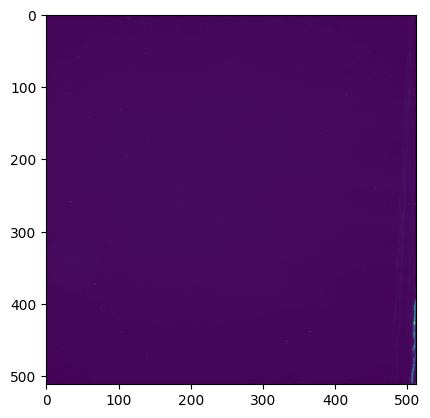

In [141]:
plt.imshow(bg_img)

In [142]:
stardist_display_folder =  processed_folder + 'obj_detect_filter_48'
obj_crop_panel_folder = processed_folder + 'obj_panel_48'
tiff_folder= processed_folder + 'obj_tiff_48'
png_folder= processed_folder + 'obj_png_48'  

if not os.path.isdir(stardist_display_folder):   os.makedirs(stardist_display_folder)
if not os.path.isdir(obj_crop_panel_folder):   os.makedirs(obj_crop_panel_folder)
if not os.path.isdir(tiff_folder):   os.makedirs(tiff_folder)
if not os.path.isdir(png_folder):   os.makedirs(png_folder)


In [149]:
cell_cropped_array =np.zeros([3000,96,96])
cell_cropped_cellalone_array =np.zeros([3000,96,96])
cell_ind=0


from skimage import filters


sigma = 1

cell_index = 0
cell_df = pd.DataFrame(columns=['folder_path','file_name','condition','date','cell_index','cx','cy','diameter','bbox_1','bbox_2','bbox_3','bbox_4','obj_folder','obj_filename'])

for row_ID in range(df.shape[0]): 
# for row_ID in range(20): 
    file_path = os.path.join(df.iloc[row_ID]['folder_path'],df.iloc[row_ID]['file_name'])    
    file_name = df.iloc[row_ID]['file_name']
    condition = df.iloc[row_ID]['condition']
    date = df.iloc[row_ID]['date']
    folder_path = df.iloc[row_ID]['folder_path']
    
    img = img_all[row_ID,:,:]
    # img = imread(file_path)
    # img = np.sqrt(img)
    smooth = filters.gaussian(img, sigma)
    img_normed = normalize(smooth,1,99)
    
    img_pad = pad_img_all[row_ID,:,:]
    labels, details = model.predict_instances(img_normed[::4,::4])
    

    us_manual = np.zeros([256,256])
    us_manual[::2,::2]=labels
    us_manual[1::2,::2]=labels
    us_manual[::2,1::2]=labels
    us_manual[1::2,1::2]=labels

    us_manual_512 = np.zeros([512,512])
    us_manual_512[::2,::2]=us_manual
    us_manual_512[1::2,::2]=us_manual
    us_manual_512[::2,1::2]=us_manual
    us_manual_512[1::2,1::2]=us_manual

    labels = us_manual_512.astype(int)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(condition+', '+date+', '+file_name)
    ax[0].imshow(img_normed, clim=(0,1), cmap='gray')    
    ax[0].axis('off')
    ax[0].set_title('img')
    ax[1].imshow(img_normed, clim=(0,1), cmap='gray')
    ax[1].imshow(labels, cmap=newmap, alpha=0.7,interpolation='None',vmax = 201,vmin = 0)
    ax[1].axis('off')
    ax[0].set_title('stardist')

    regionprops_pax = regionprops(labels,intensity_image=img)
    for region_i in range(0,labels.max()):
        # print([regionprops_pax[region_i]['Area'],regionprops_pax[region_i]['Eccentricity']])
        if(regionprops_pax[region_i]['Eccentricity']>0.6):
            labels[labels==region_i+1] =0
        if(regionprops_pax[region_i]['Area']<300):
            labels[labels==region_i+1] =0

    
    ax[2].imshow(img_normed, clim=(0,1), cmap='gray')
    ax[2].imshow(labels, cmap=newmap, alpha=0.7,interpolation='None',vmax = 201,vmin = 0)
    ax[2].axis('off')
    ax[2].set_title('filtered')

    fig.savefig(os.path.join(stardist_display_folder, condition+'-'+date+'-'+file_name+'_stardist_filter.png'))
    plt.close(fig)


    labels_pad = np.zeros_like(img_pad)
    labels_pad[64:64+512,64:64+512] = labels
    
    label_refined_pad = label(labels_pad>0)
    regionprops_refined = regionprops(label_refined_pad,intensity_image=img_pad)
    
    if len(regionprops_refined) == 0:
        continue
    else:
        fig2, ax2 = plt.subplots(1, len(regionprops_refined), figsize=(12, 4))

    fig2.suptitle(condition+', '+date+', '+file_name)
    for obj_i in range(len(regionprops_refined)):
        Centroid = regionprops_refined[obj_i]['Centroid']
        BBox = regionprops_refined[obj_i]['bbox']
        Diameter = regionprops_refined[obj_i]['equivalent_diameter_area']
        cell_ID = regionprops_refined[obj_i]['label']
        
        cx = round(Centroid[0])
        cy = round(Centroid[1])
        crop_img = img_pad[cx-48:cx+48,cy-48:cy+48]
        crop_label = (label_refined_pad[cx-48:cx+48,cy-48:cy+48]).copy().astype(float)

        crop_img_cellalone = np.zeros_like(crop_img)+bg_int-40


        mask = crop_label==cell_ID
        mask_smooth = filters.gaussian(mask.astype(float), sigma)
        mask_smooth_bw = mask_smooth>0.1

        crop_img_cellalone[mask_smooth_bw>0] = crop_img[mask_smooth_bw>0]
        cell_cropped_array[cell_ind,:,:] = crop_img
        cell_cropped_cellalone_array[cell_ind,:,:]=crop_img_cellalone
        cell_ind = cell_ind+1

        if len(regionprops_refined) == 1:
            ax2.imshow(crop_img_cellalone,cmap='gray',vmin=80,vmax=500)
            ax2.axis('off')
            ax2.set_title('obj '+str(obj_i).zfill(2))
        else:
            ax2[obj_i].imshow(crop_img_cellalone,cmap='gray',vmin=80,vmax=500)
            ax2[obj_i].axis('off')
            ax2[obj_i].set_title('obj '+str(obj_i).zfill(2))


        cell_index = cell_index + 1
        
        obj_filename = condition+'-'+date+'-'+ file_name + '_obj_'+str(obj_i).zfill(2)+'.png'
        tifffile.imsave(os.path.join(png_folder, obj_filename),crop_img.astype(np.float16))  
        
        obj_filename = condition+'-'+date+'-'+ file_name + '_obj_'+str(obj_i).zfill(2)+'.tif'
        tifffile.imwrite(os.path.join(tiff_folder, obj_filename),crop_img.astype(np.float16))  

        obj_filename = condition+'-'+date+'-'+ file_name + '_obj_'+str(obj_i).zfill(2)+'_cellalone.png'
        tifffile.imsave(os.path.join(png_folder, obj_filename),crop_img_cellalone.astype(np.float16))  
        
        obj_filename = condition+'-'+date+'-'+ file_name + '_obj_'+str(obj_i).zfill(2)+'_cellalone.tif'
        tifffile.imwrite(os.path.join(tiff_folder, obj_filename),crop_img_cellalone.astype(np.float16))  
        
        
        s = pd.DataFrame([[folder_path, file_name, condition,date,cell_index,Centroid[0],Centroid[1],Diameter,BBox[0],BBox[1],BBox[2],BBox[3],tiff_folder,obj_filename]],
                         columns=['folder_path','file_name','condition','date','cell_index','cx','cy','diameter','bbox_1','bbox_2','bbox_3','bbox_4','obj_folder','obj_filename'])
        
        cell_df = pd.concat([cell_df, s], ignore_index=True)

    fig2.savefig(os.path.join(obj_crop_panel_folder, condition+'-'+date+'-'+file_name+'_obj_crop_panel.png'))
    
    plt.close(fig2)

tifffile.imwrite(os.path.join(tiff_folder, 'all_cell_cropped_array.tiff'),cell_cropped_array.astype(np.float16))  


2542260819.py (122): <tifffile.imsave> is deprecated. Use tifffile.imwrite
2542260819.py (128): <tifffile.imsave> is deprecated. Use tifffile.imwrite


In [160]:
cell_df.iloc[199].obj_filename


'1_10 Tau_Tubulin-Date 4-1 uM tau + mt encap GUV35_w2640.TIF_obj_08_cellalone.tif'

In [147]:
bg_int

122

In [132]:
file_name

'Image10_MT.TIF'

In [112]:
img_pad.shape

(640, 640)

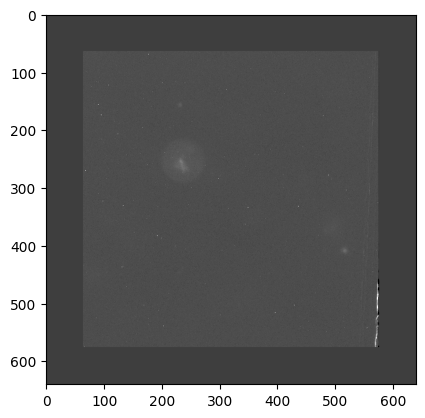

In [137]:
plt.imshow(img_pad,vmin=0,vmax=500,cmap='gray')

In [108]:
Diameter

62.45963468567951

In [107]:
Centroid

(133.15535248041775, 542.3328981723238)

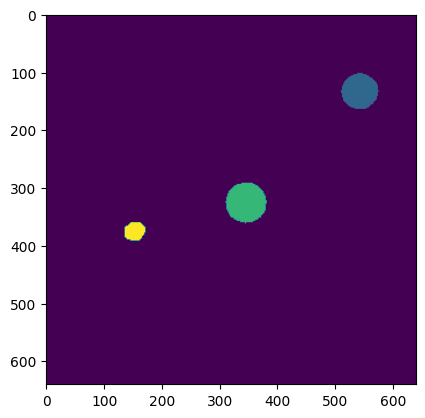

In [106]:
plt.imshow(label_refined_pad)

In [105]:
img.shape

(512, 512)

In [104]:
cy

606

In [100]:
label_refined.shape

(512, 512)

In [94]:
img_pad.shape

(640, 640)

In [93]:
us_manual.shape

(512, 512)

In [92]:
labels.shape

(512, 512)

In [90]:
crop_img_cellalone.shape

(96, 96)

In [85]:
label_refined.max()

3

In [91]:
crop_label.shape

(96, 40)

In [61]:
crop_img_norm = crop_img -90
crop_img_norm = crop_img_norm*2
from PIL import Image
image = Image.fromarray(crop_img_norm)
grayscale_image = image.convert("L")
# Save the image in a different format
grayscale_image.save("/mnt/d/lding/CLS/mousumiLiuDinner/test.png")

In [50]:
crop_img.max()

188.0

In [59]:
crop_img.min()

107.0

In [42]:
labels, details = model.predict_instances(img_normed[::2,::2])
    

us_manual = np.zeros([512,512])
us_manual[::2,::2]=labels
us_manual[1::2,::2]=labels
us_manual[::2,1::2]=labels
us_manual[1::2,1::2]=labels

labels = us_manual

In [38]:
us_manual = np.zeros([512,512])
us_manual[::2,::2]=labels
us_manual[1::2,::2]=labels
us_manual[::2,1::2]=labels
us_manual[1::2,1::2]=labels

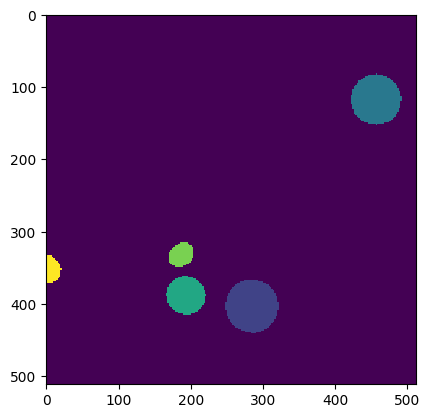

In [43]:
plt.imshow(labels,interpolation='None')

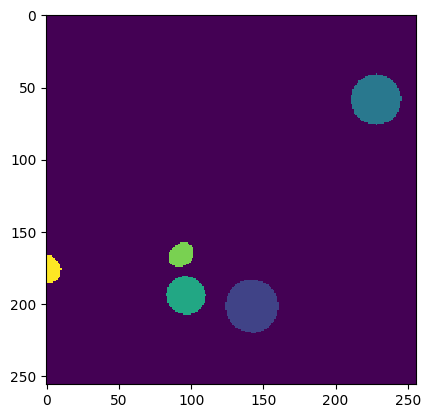

In [31]:
plt.imshow(labels,interpolation='None')

In [33]:
labels2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [79]:
ax2.imshow(img)

In [80]:
len(regionprops_refined)

1

In [72]:
len(regionprops_refined)

1

In [71]:
obj_i

0

In [164]:
cell_df.to_csv('/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Microtubule_GUV-Liu-20250106T211105Z-001/cell_df.csv')

In [168]:
cell_df.iloc[100].obj_folder

'/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/obj_tiff_48'

In [169]:
cell_df.iloc[100].obj_filename


'1_10 Tau_Tubulin-Date 3-Image 9_MT.TIF_obj_06_cellalone.tif'

In [163]:
s.folder_path[0]


'/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/Microtubule_GUV-Liu-20250106T211105Z-001/Microtubule_GUV-Liu/3_10 Tau_Tubulin/Date 5/Microtubule'

In [58]:
s

,folder_path,file_name,condition,date
0,/mnt/d/lding/CLS/mousumiLiuDinner/raw_data/3_1...,Image 9_MT.TIF,3_10 Tau_Tubulin,Date 3


In [49]:
file_name

'Image6_MT.TIF'

In [46]:

regionprops_refined[obj_i].equivalent_diameter_area

41.90223540802793

In [47]:
regionprops_refined[obj_i].area

1379.0

In [48]:
np.pi*20*20

1256.6370614359173

In [ ]:
plt.imshow(img_pad,cmap='gray',vmin=80,vmax=500)

In [ ]:
img_pad.shape

In [ ]:
pad_img_all_norm[row_ID,:,:].min() 

In [57]:
label_refined = label(labels>0)
regionprops_refined = regionprops(label_refined,intensity_image=img_ds_norm)

In [ ]:
len(regionprops_refined)

In [ ]:
regionprops_pax[0]

In [ ]:
labels.max()

In [ ]:
df.shape

In [ ]:
# display image and overlay labels(segmented cells) in different colors
plt.figure(figsize=(4,4))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')

In [30]:
# save the segmentation results -- the labels, to a tif file for future evaluation 
output_dir = 'D:\lding\dsi_clinic\cellsegmentation\data\\tissuenet_v1.1\\tissuenet_v1.1_test\C0_selected_seg_stardist'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

imwrite(os.path.join(output_dir, 'testimage_labels.tif'), labels)

### Or wrap these into a function to make test more convenient

In [23]:
def example(model, i, show_dist=True):
    img = normalize(images[i], 1,99.8, axis=[0,1])
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(7,5))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# run current model for image number 42
example(model, 42)

In [ ]:
# run current model for image number 1 without displaying the boundary distances
example(model, 162, False)

In [ ]:
# load another pretrained model 
model_versatile = StarDist2D.from_pretrained('2D_versatile_fluo')

In [ ]:
# run model '2D_versatile_fluo' for image number 30 without displaying the boundary distances
example(model_versatile, 30, False)